In [0]:
import os
import glob
import zipfile
import pathlib
import cv2
import math
import random
import shutil
import skimage as sk
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.activations import softmax, relu
from keras.layers import Activation, Dense, Dropout, Flatten, Lambda, Cropping2D, LSTM
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


## Ran the new few blocks for my colab configuration, can be ignored.

In [36]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [37]:
!wget https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip


--2019-04-14 10:46:55--  https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 52.85.159.80, 52.85.159.38, 52.85.159.165, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|52.85.159.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 333137665 (318M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 317.70M  42.5MB/s    in 7.2s    

2019-04-14 10:47:03 (43.9 MB/s) - ‘data.zip’ saved [333137665/333137665]



In [0]:
import shutil

shutil.move("/content/data.zip", "/content/gdrive/My Drive/udacity-behavioural-cloning/")

'/content/gdrive/My Drive/udacity-behavioural-cloning/data.zip'

In [0]:
os.chdir('/content/gdrive/My Drive/udacity-behavioural-cloning/')

In [0]:
with zipfile.ZipFile('data.zip') as f:
  f.extractall()

In [0]:
os.chdir('/content/gdrive/My Drive/udacity-behavioural-cloning/data/')

## Training code starts here

In [0]:
df = pd.read_csv('driving_log.csv')

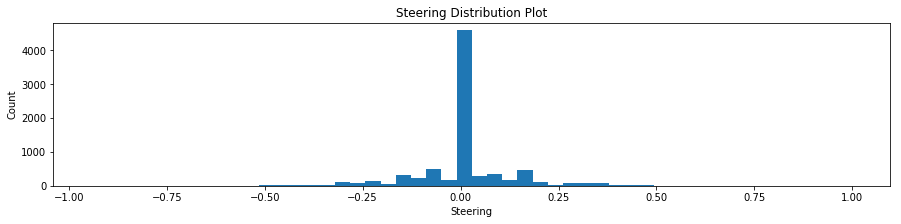

In [42]:
# Visualizing original distribution

plt.figure(figsize=(15, 3))
hist, bins = np.histogram(df.steering.values, bins=50)
plt.hist(df.steering.values, bins=bins)
plt.title('Steering Distribution Plot')
plt.xlabel('Steering')
plt.ylabel('Count')
plt.show()

In [0]:
# create grayscale image
def grayscale(img):
  return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# normalize image to zero mean
def normalize(img):
  mean = np.mean(img)
  std = np.std(img)
  return (img-mean)/std
# preprocess with grayscale and normalization
def preprocess(img):
  return normalize(grayscale(img))
# augment image, left right flip for now
def augment(image, randn):
  return np.flip(image, axis=randn%2).astype(np.uint8)
# yeo-johnson bias
def yeo_johnson_bias(steering):
  if steering >= 0:
      return np.log(steering + 1)
  elif steering < 0:
      return -np.log(-steering + 1)

In [0]:
# To separate center, left and right
df_center = pd.concat([df.center, df.steering], axis=1).rename(index=str, columns={'center': 'img'})
df_left = pd.concat([df.left, df.steering], axis=1).rename(index=str, columns={'left': 'img'})
df_right = pd.concat([df.right, df.steering], axis=1).rename(index=str, columns={'right': 'img'})

df_center.head()

,img,steering
0,IMG/center_2016_12_01_13_30_48_287.jpg,0.0
1,IMG/center_2016_12_01_13_30_48_404.jpg,0.0
2,IMG/center_2016_12_01_13_31_12_937.jpg,0.0
3,IMG/center_2016_12_01_13_31_13_037.jpg,0.0
4,IMG/center_2016_12_01_13_31_13_177.jpg,0.0


In [0]:
# Adjusting the steering value 0 for left and right

for k, v in df_left.iterrows():
  if v.steering == 0:
    df_left.loc[k, 'steering'] = df_left.loc[k, 'steering'] + random.uniform(0.2, 0.5)
  
for k, v in df_right.iterrows():
  if v.steering == 0:
    df_right.loc[k, 'steering'] = df_right.loc[k, 'steering'] + random.uniform(-0.2, -0.5)

In [0]:
new_df = pd.concat([df_center, df_left, df_right], axis=0, ignore_index=True, sort=False)

In [0]:
new_df.tail()

,img,steering
24103,IMG/right_2016_12_01_13_46_38_745.jpg,-0.499654
24104,IMG/right_2016_12_01_13_46_38_802.jpg,-0.236362
24105,IMG/right_2016_12_01_13_46_38_846.jpg,-0.291893
24106,IMG/right_2016_12_01_13_46_38_922.jpg,-0.356710
24107,IMG/right_2016_12_01_13_46_38_947.jpg,-0.226685


In [0]:
new_df.to_csv('adjusted_log.csv', index=False, encoding='utf-8')

In [0]:
df = pd.read_csv('adjusted_log.csv')

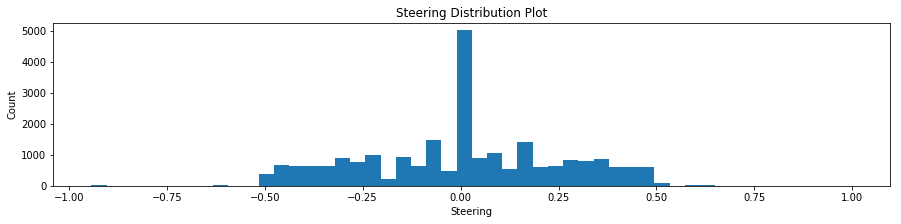

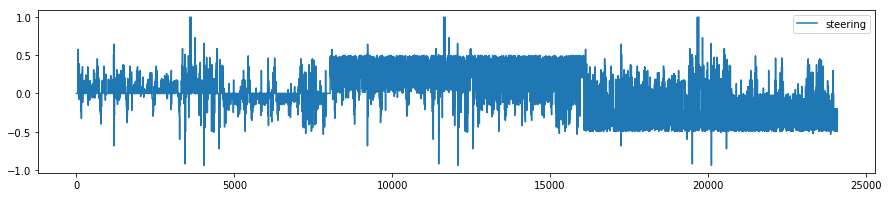

In [44]:
# Visualizing adjusted distribution

plt.figure(figsize=(15, 3))
hist, bins = np.histogram(df.steering.values, bins=50)
plt.hist(df.steering.values, bins=bins)
plt.title('Steering Distribution Plot')
plt.xlabel('Steering')
plt.ylabel('Count')
plt.show()

df.plot(figsize=(15, 3))

In [45]:
df.shape

(24108, 2)

In [0]:
# Grouping all images and steering together, to do a train test splitting

images = df.img.tolist()
steering = df.steering.tolist()

img_list = []
for img, angle in zip(images, steering):
  row = [img, angle]
  img_list.append(row)

train_samples, validation_samples = train_test_split(img_list, test_size=0.2)

In [0]:
# Data generator

def generator(samples, batch_size=32):
    cwd = os.getcwd()
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []

            for batch_sample in batch_samples:
                name = os.path.join(cwd, batch_sample[0].strip())
                try:
                  # normalizing image
                  image = normalize(mpimg.imread(name))
                  # reshaping image into its rgb form
                  image = np.reshape(image, (image.shape[0], image.shape[1], 3))
                  steering = float(batch_sample[1])
                  images.append(image)
                  angles.append(steering)
                # if image not found, skip the image
                except FileNotFoundError as msg:
                  print(msg)
                  continue

            # trim image to only see section with road|
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

In [0]:
# Set our batch size
batch_size = 32

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

In [0]:
### PART 3: TRAINING ###
# Training Architecture: inspired by NVIDIA architecture #
INPUT_SHAPE = (160, 320, 3)
model = Sequential()
model.add(Cropping2D(cropping=((70,25), (0, 0)), input_shape=INPUT_SHAPE))

model.add(Conv2D(filters=24, kernel_size=5, strides=(2, 2), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=36, kernel_size=5, strides=(2, 2), activation='relu'))
#model.add(BatchNormalization())
model.add(Conv2D(filters=48, kernel_size=5, strides=(2, 2), activation='relu'))
#model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=3, strides=(1, 1), activation='relu'))
#model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=3, strides=(1, 1), activation='relu'))

model.add(Flatten())
model.add(Dense(1164, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
adam = Adam(lr = 0.0001)
model.compile(optimizer= adam, loss='mse', metrics=['accuracy'])
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 158, 24)       1824      
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 158, 24)       96        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)    

In [0]:
history = model.fit_generator(generator=train_generator, steps_per_epoch=math.ceil(len(train_samples)/ batch_size), \
                    epochs=15, verbose=1, validation_data=validation_generator, \
                    validation_steps=math.ceil(len(validation_samples)/ batch_size), use_multiprocessing=False)

print('Done Training')

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
603/603 [==============================] - 197s 326ms/step - loss: 0.0531 - acc: 0.1800 - val_loss: 0.0418 - val_acc: 0.1839
Epoch 2/15
603/603 [==============================] - 193s 320ms/step - loss: 0.0435 - acc: 0.1801 - val_loss: 0.0393 - val_acc: 0.1839
Epoch 3/15
603/603 [==============================] - 194s 321ms/step - loss: 0.0407 - acc: 0.1801 - val_loss: 0.0380 - val_acc: 0.1839
Epoch 4/15
603/603 [==============================] - 194s 321ms/step - loss: 0.0381 - acc: 0.1801 - val_loss: 0.0363 - val_acc: 0.1839
Epoch 5/15
603/603 [==============================] - 193s 320ms/step - loss: 0.0370 - acc: 0.1801 - val_loss: 0.0369 - val_acc: 0.1839
Epoch 6/15
603/603 [==============================] - 193s 319ms/step - loss: 0.0349 - acc: 0.1801 - val_loss: 0.0355 - val_acc: 0.1839
Epoch 7/15
603/603 [==============================] - 193s 320ms/step - loss: 0.0331 - acc: 0.1802 - val_loss: 0.0353 - val_acc: 0.1839


In [0]:
###Saving Model and Weights###
model_json = model.to_json()
with open("model5.json", "w") as json_file:
  json_file.write(model_json)
model.save('model5.h5')
model.save_weights("model_weights5.h5")
print("Saved model to disk")

Saved model to disk


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


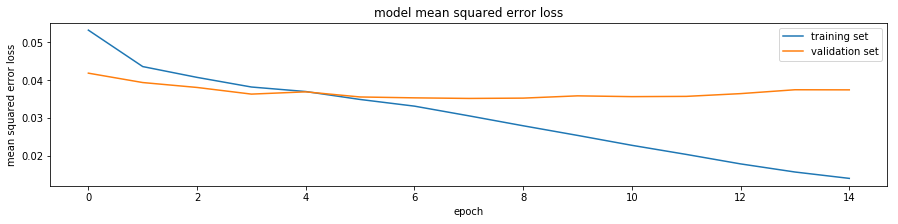

In [31]:
### print the keys contained in the history object
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.figure(figsize=(15, 3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()